In [ ]:
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     ----------------------- ---------------- 3.7/6.2 MB 19.8 MB/s eta 0:00:01
     ---------------------------------------- 6.2/6.2 MB 18.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
     -------------------------------------- 536.2/536.2 kB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 GB 20.9 MB/s eta 0:02:11
   ---------------------------------------- 0.0/2.7 GB 20.7 MB/s eta 0:02:12
   ---------------------------------------- 0.0/2.7 GB 21.0 MB/s eta 0:02:10
   ---------------------------------------- 0.0/2.7 GB 20.5 MB/s eta 0:02:13
   ---------------------------------------- 0.0/2.7 GB 21.8 MB/s eta 0:02:05
   ---------------------------------------- 0.0/2.7 GB 23.0 MB/s eta 0:01:58
    ------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.23 requires simsimd>=5.9.2, which is not installed.
albucore 0.0.23 requires stringzilla>=3.10.4, which is not installed.
albumentations 2.0.0 requires pydantic>=2.9.2, which is not installed.
albumentations 2.0.0 requires PyYAML, which is not installed.
albumentations 2.0.0 requires scipy>=1.10.0, which is not installed.


In [ ]:
# ! pip install numba==0.61.0 torchaudio==2.6.0 librosa==0.10.2

In [4]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.6.0+cu118
11.8
True


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import torchaudio.transforms as T
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing data

In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import MinMaxScaler

# lấy 22050 mẫu mỗi giây
def load_and_resample_audio(audio_path, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)
    return y, sr

# windownwing - Fourier Transform - Mel Filter Bank - Log - DCT
def extract_mfcc(y, sr, n_mfcc=13, n_fft=2048, hop_length=512):
    mfcc = librosa.feature.melspectrogram(
        y, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

def audio_to_melspec(audio, sr, n_mels, n_fft=2048, hop_length=512, to_db=False):
    """
    Chuyển đổi tín hiệu âm thanh thành Mel Spectrogram.

    Parameters:
    - audio: dữ liệu âm thanh đầu vào.
    - sr: tần số lấy mẫu (sampling rate).
    - n_mels: số lượng mel bands.
    - n_fft: độ dài cửa sổ FFT (default=2048). (giống seq_length)
    - hop_length: bước nhảy giữa các cửa sổ FFT (default=512). (giống stride)
    - to_db: có chuyển sang đơn vị decibel (dB) hay không (default=False).

    - overlaps = n_fft - hop_length = 1536 (tiêu chuẩn là hop_length = n_fft/4)
    Returns:
    - spec: Mel Spectrogram dưới dạng ma trận.
    """
    # Tạo Mel spectrogram từ audio input
    spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=None,            # Độ dài cửa sổ (mặc định = n_fft)
        window="hann",              # Loại cửa sổ sử dụng để tránh gián đoạn tín hiệu
        center=True,                # Thêm padding vào đầu/cuối tín hiệu
        pad_mode="reflect",         # Kiểu padding
        power=2.0,                  # Bình phương giá trị trong melspectrogram
        n_mels=n_mels               # Số lượng Mel filter
    )

    # Chuyển đổi Mel spectrogram sang đơn vị dB nếu cần
    if to_db:
        spec = librosa.power_to_db(spec, ref=np.max)

    return spec


def normalize_melspec(melspec, norm_range=(0, 1)):
    """
    Chuẩn hóa Mel spectrogram về khoảng giá trị mong muốn (mặc định từ 0 đến 1).
    """
    scaler = MinMaxScaler(feature_range=norm_range)
    melspec = melspec.T  # chuyển vị để chuẩn hóa theo đúng trục thời gian
    melspec_normalized = scaler.fit_transform(melspec)
    return melspec_normalized.T  # chuyển vị lại về dạng ban đầu

def denormalize_melspec(melspec_normalized, original_melspec, norm_range=(0, 1)):
    """
    Khôi phục Mel spectrogram từ dữ liệu đã chuẩn hóa về giá trị gốc.
    """
    scaler = MinMaxScaler(feature_range=norm_range)
    melspec = original_melspec.T  # dùng dữ liệu gốc để lấy lại scale ban đầu
    scaler.fit(melspec)
    melspec_denormalized = scaler.inverse_transform(melspec_normalized.T)
    return melspec_denormalized.T  # chuyển vị lại về dạng ban đầu


def melspec_to_audio(melspec, sr, n_fft=2048, hop_length=512, n_iter=64):
    """
    Chuyển đổi Mel spectrogram về dạng tín hiệu âm thanh.

    Parameters:
    - melspec: Mel spectrogram đầu vào.
    - sr: Tần số lấy mẫu.
    - n_fft: Kích thước FFT.
    - hop_length: Bước nhảy giữa các cửa sổ FFT.
    - n_iter: Số lần lặp của thuật toán Griffin-Lim (để tái tạo phase).

    Returns:
    - audio_reconstructed: Tín hiệu âm thanh được tái tạo từ Mel spectrogram.
    """
    # Chuyển Mel spectrogram từ dB về power nếu có giá trị âm
    if np.any(melspec < 0):
        melspec = librosa.db_to_power(melspec)

    # Chuyển đổi Mel spectrogram thành tín hiệu âm thanh sử dụng thuật toán Griffin-Lim
    audio_reconstructed = librosa.feature.inverse.mel_to_audio(
        melspec,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=None,
        window="hann",
        center=True,
        pad_mode="reflect",
        power=2.0,
        n_iter=n_iter
    )
    return audio_reconstructed


def display_audio_files(reconstructed_audio, sr, title="", original_audio=None):
    """
    Hiển thị âm thanh gốc (nếu có) và âm thanh được tái tạo.

    Parameters:
    - reconstructed_audio: âm thanh tái tạo từ Mel Spectrogram.
    - sr: tần số lấy mẫu của âm thanh.
    - title: tiêu đề hiển thị nếu không có âm thanh gốc.
    - original_audio: âm thanh gốc ban đầu (nếu có).
    """
    if original_audio is not None:
        print("Original Audio:")
        ipd.display(ipd.Audio(original_audio, rate=sr))
        print("Reconstructed Audio (from Mel Spectrogram):")
    else:
        print(title)

    ipd.display(ipd.Audio(reconstructed_audio, rate=sr))


def show_spectrogram(spectrogram, title="Mel-Spectrogram", denormalize=False, is_numpy=False):
    """
    Hiển thị ảnh của Mel Spectrogram.

    Parameters:
    - spectrogram: dữ liệu Mel Spectrogram cần hiển thị.
    - title: tiêu đề của biểu đồ.
    - denormalize: True nếu muốn hiển thị spectrogram đã denormalize.
    - is_numpy: True nếu spectrogram đã là numpy array, False nếu là tensor PyTorch.
    """
    if not is_numpy:
        spectrogram = spectrogram.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 4))

    if denormalize:
        plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis")
    else:
        plt.imshow(spectrogram, aspect="auto", origin="lower",
                   cmap="viridis", vmin=0, vmax=1)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar()
    plt.show()

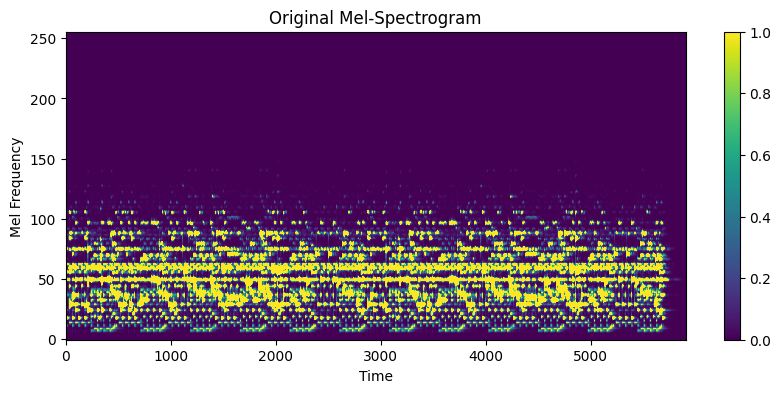

In [9]:
audio, target_sr = load_and_resample_audio(os.path.join(
    "../","crawled_piano_audio_40_pages", "crawled_data", "audio", "audio_0001.mp3"))

mel_spectrogram = audio_to_melspec(audio, target_sr, n_mels=256)

show_spectrogram(
    mel_spectrogram, title="Original Mel-Spectrogram", is_numpy=True)

In [17]:
def load_and_get_genre_data(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    return data.get("genres", [])

def get_id2label_label2id(data_path):
    genres = []
    for audio_file in os.listdir(data_path):
        if not audio_file.endswith(".json"):
            continue
        genres_one_sample = load_and_get_genre_data(os.path.join(data_path, audio_file))
        genres.extend(genres_one_sample)
        genres = list(set(genres))
        id2label = {i: genre for i, genre in enumerate(genres)}
        label2id = {genre: i for i, genre in enumerate(genres)}
    return id2label, label2id


id2label, label2id = get_id2label_label2id('../crawled_piano_audio_40_pages/crawled_data')
print(label2id)
print(id2label)

{'Piano': 0, 'Rap': 1, 'Techno': 2, 'Ambient Electronic': 3, 'Big Band/Swing': 4, 'Americana': 5, 'Gospel': 6, 'Synth Pop': 7, 'Afrobeat': 8, 'Spoken': 9, '20th Century Classical': 10, 'Kid-Friendly': 11, 'Jazz': 12, 'Classical': 13, 'British Folk': 14, 'Europe': 15, 'Lo-fi Experimental': 16, 'Jazz: Out': 17, 'Rock': 18, 'Pop': 19, 'Chill-out': 20, 'Improv': 21, 'Contemporary Classical': 22, 'Hip-Hop': 23, 'Historic': 24, 'Hiplife': 25, 'African': 26, 'Vaporwave': 27, 'Sound Effects': 28, 'Instrumental': 29, 'Tango': 30, 'Nerdcore': 31, 'Comedy': 32, 'Radio': 33, 'Metal': 34, 'Progressive': 35, 'Acoustic': 36, 'Dance': 37, 'Electroacoustic': 38, 'Wonky': 39, 'House': 40, 'Lo-fi Hip-Hop': 41, 'Country & Western': 42, 'Sound Poetry': 43, 'Downtempo': 44, 'Radio Art': 45, 'Electronic': 46, 'Celtic': 47, 'Drone': 48, 'Jungle': 49, 'Composed Music': 50, 'Lounge': 51, 'Singer-Songwriter': 52, 'Christmas': 53, 'International': 54, 'Avant-Garde': 55, 'Talk Radio': 56, 'Goth': 57, 'Modern Jazz'